# Homographic transformation

tailtop
tailbot
dorsalback
dorsalfront
pectoral
eye
snouttop
snoutbot
tailtop
tailbot
dorsalback
dorsalfront
pectoral
eye
snoutbot
snouttop
Homography matrix:
[[ 1.91850588e+00 -1.54136009e+00  1.08853742e+01]
 [-1.25217679e-02  4.06415058e-01  1.57097422e+02]
 [ 6.90691260e-04 -1.43781113e-03  1.00000000e+00]]
Warped image dimensions: (489, 1525, 3)
[[array([  1.50851392, 162.98982376]), array([-414.55690844,  477.67317401])], [array([710.47205758, 113.06390102]), array([867.3354445 , 135.77627825])], [array([689.78527859, 145.41996084]), array([1079.69430111,  391.17183237])], [array([674.72221936, 429.95468618]), array([1093.32478093,  410.0515747 ])], [array([1293.42132866,  235.09339774]), array([1373.16890908,  272.16132181])]]


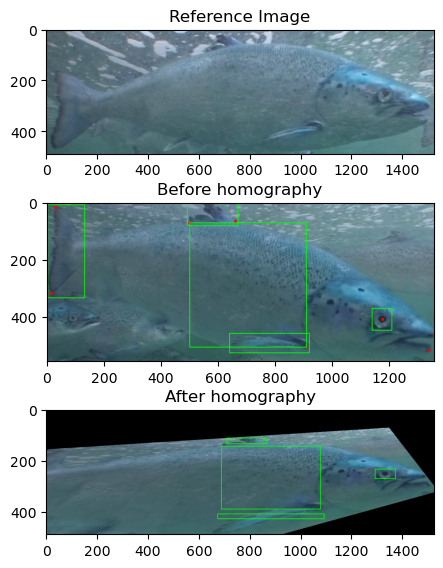

In [19]:
import numpy as np
import cv2
import json, os
import matplotlib.pyplot as plt

from_path = "/Users/magnuswiik/prosjektoppgave_data/Masteroppgave_data/Helfisk_Landmark_Deteksjonssett/fish5/"

# Good example
annots = ["fish9_GP020101_00005879.json", "fish9_GP020101_00005919.json"]
imgs = ["fish9_GP020101_00005879.jpg", "fish9_GP020101_00005919.jpg"]

# Bad example
annots = ["fish5_GP020101_00008309.json", "fish5_GP020101_00013564.json"]
imgs = ["fish5_GP020101_00008309.jpg", "fish5_GP020101_00013564.jpg"]

img1 = cv2.imread(from_path + imgs[0], cv2.IMREAD_COLOR)
img2 = cv2.imread(from_path + imgs[1], cv2.IMREAD_COLOR)

# Extract location of good matches
points1 = np.zeros((8, 2), dtype=np.float32)
boxes1 = np.zeros((5, 6), dtype=np.float32)
points2 = np.zeros((8, 2), dtype=np.float32)
boxes2 = np.zeros((5, 6), dtype=np.float32)

for i in range(len(imgs)):
    index_point = 0 
    index_box = 0 
    with open(from_path + annots[i], 'r') as file:
            img = cv2.imread(from_path + imgs[i], cv2.IMREAD_COLOR)
            content = json.load(file)
            shapes = content['shapes']
            
            for shape in shapes:
                if shape['shape_type'] == 'point':
                    point = shape['points']
                    print(shape['label'])
                    x1 = float(point[0][0])
                    y1 = float(point[0][1])
                    if i == 0:
                        points1[index_point] = [x1, y1]
                    else:
                        points2[index_point] = [x1, y1]
                    index_point += 1
                if shape['shape_type'] == 'rectangle':
                    box = shape['points']
                    x1 = float(box[0][0])
                    y1 = float(box[0][1])
                    x2 = float(box[1][0])
                    y2 = float(box[1][1])
                    if i == 0:
                        boxes1[index_box] = [x1, y1, 1, x2, y2, 1]
                    else:
                        boxes2[index_box] = [x1, y1, 1, x2, y2, 1]
                    index_box += 1
                    
                
# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
print("Homography matrix:")
print(h)

# Use homography
height, width, channels = img2.shape
img2Reg = cv2.warpPerspective(img1, h, (width, height))
print("Warped image dimensions:", img2Reg.shape)

transformed_points = []

# Apply homogeneous transformation
for points in boxes1:
    point1 = points[:3]
    point2 = points[3:]
    transformed_point1 = np.dot(h, point1)
    transformed_point2 = np.dot(h, point2)
    normalized_point1 = transformed_point1[:2]/transformed_point1[2]
    normalized_point2 = transformed_point2[:2]/transformed_point2[2]
    transformed_points.append([normalized_point1, normalized_point2])
    
print(transformed_points)

for box in transformed_points:
    min, max = box
    cv2.rectangle(img2Reg, (int(min[0]), int(min[1])), (int(max[0]), int(max[1])), (0, 255, 0), 2)

# Add points to image
for point in points1:
    cv2.circle(img1, (int(point[0]), int(point[1])), 5, (255, 0, 0), -1)

# Add boxes to image
for box in boxes1:
    min, max = box[:3], box[3:]
    cv2.rectangle(img1, (int(min[0]), int(min[1])), (int(max[0]), int(max[1])), (0, 255, 0), 2)

# Display images
fig, axs = plt.subplots(3, 1, figsize=(5, 7))

axs[0].imshow(img2)
axs[0].set_title('Reference Image')

axs[1].imshow(img1)
axs[1].set_title('Before homography')

axs[2].imshow(img2Reg)
axs[2].set_title('After homography')


plt.show()

